In [3]:
from dataset_for_centercrop import Radiate_Dataset
from PIL import Image
import cv2
import numpy as np
import torch
import argparse
import os


In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--data_folder", help="root folder with radiate dataset", 
                    default='/workspace/dataset/radiate', type=str)

parser.add_argument("--train_mode", help="dataset mode ('train_good_weather', 'train_good_and_bad_weather', 'test')",
                    default='train_good_and_bad_weather', type=str)

args = parser.parse_args(args=[])
data_folder = args.data_folder
train_mode = args.train_mode


In [5]:
def gen_boundingbox(bbox, angle):
    theta = np.deg2rad(-angle)
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta), np.cos(theta)]])
    
    x1 = bbox[0] - bbox[2] / 2
    y1 = bbox[1] - bbox[3] / 2
    x2 = bbox[0] + bbox[2] / 2
    y2 = bbox[1] + bbox[3] / 2
    
    points = np.array([[x1, y1],
                       [x2, y1],
                       [x2, y2],
                       [x1, y2]]).T

    cx = bbox[0]
    cy = bbox[1]

    T = np.array([[cx], [cy]])

    points = points - T
    points = np.matmul(R, points) + T
    points = points.astype(float)
    
    return points

10
(8, 5)
[ True  True  True  True  True  True  True  True]
[567 482 583 482 583 506 567 506]
[567 482 583 482 583 506 567 506]
[ True  True  True  True  True  True  True  True]
[565 396 578 396 578 422 565 422]
[565 396 578 396 578 422 565 422]
[ True  True  True  True  True  True  True  True]
[553 322 569 321 571 345 554 346]
[553 322 569 321 571 345 554 346]
[ True  True False  True  True  True  True  True]
[549 271 563 269 565 294 551 295]
[549 271 562 269 565 294 551 295]
[ True  True  True False  True  True  True  True]
[607 286 587 287 586 260 606 259]
[607 286 587 286 586 260 606 259]
[False  True  True False  True  True  True  True]
[638 428 621 431 609 364 626 361]
[637 428 621 430 609 364 626 361]
[ True  True  True  True  True  True  True  True]
[533 156 548 155 549 177 535 178]
[533 156 548 155 549 177 535 178]
[ True  True  True  True  True  True  True  True]
[518  70 537  67 540  86 521  89]
[518  70 537  67 540  86 521  89]


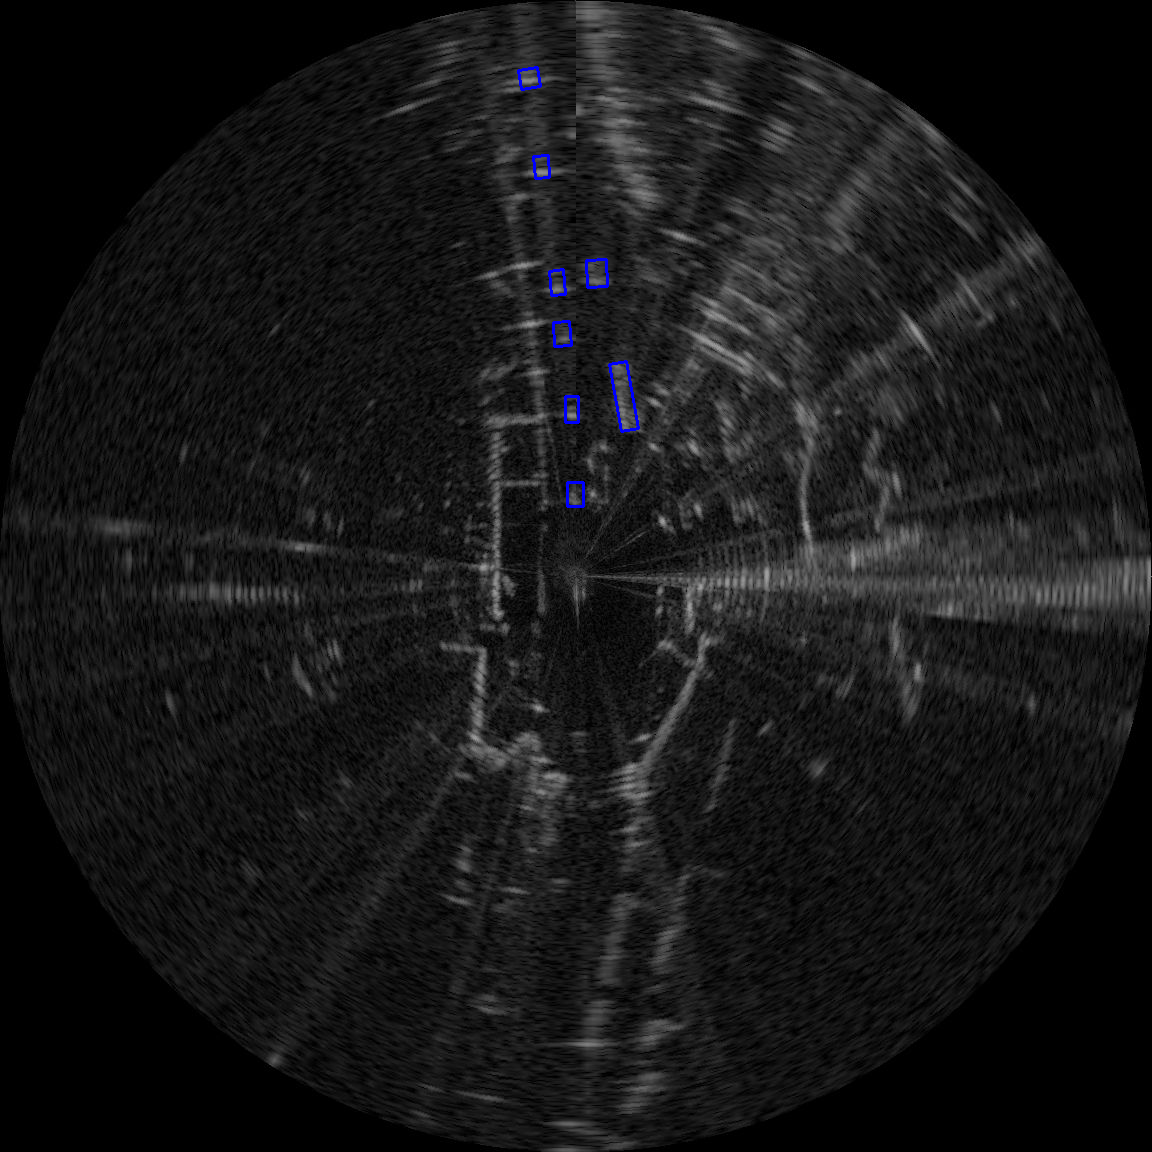

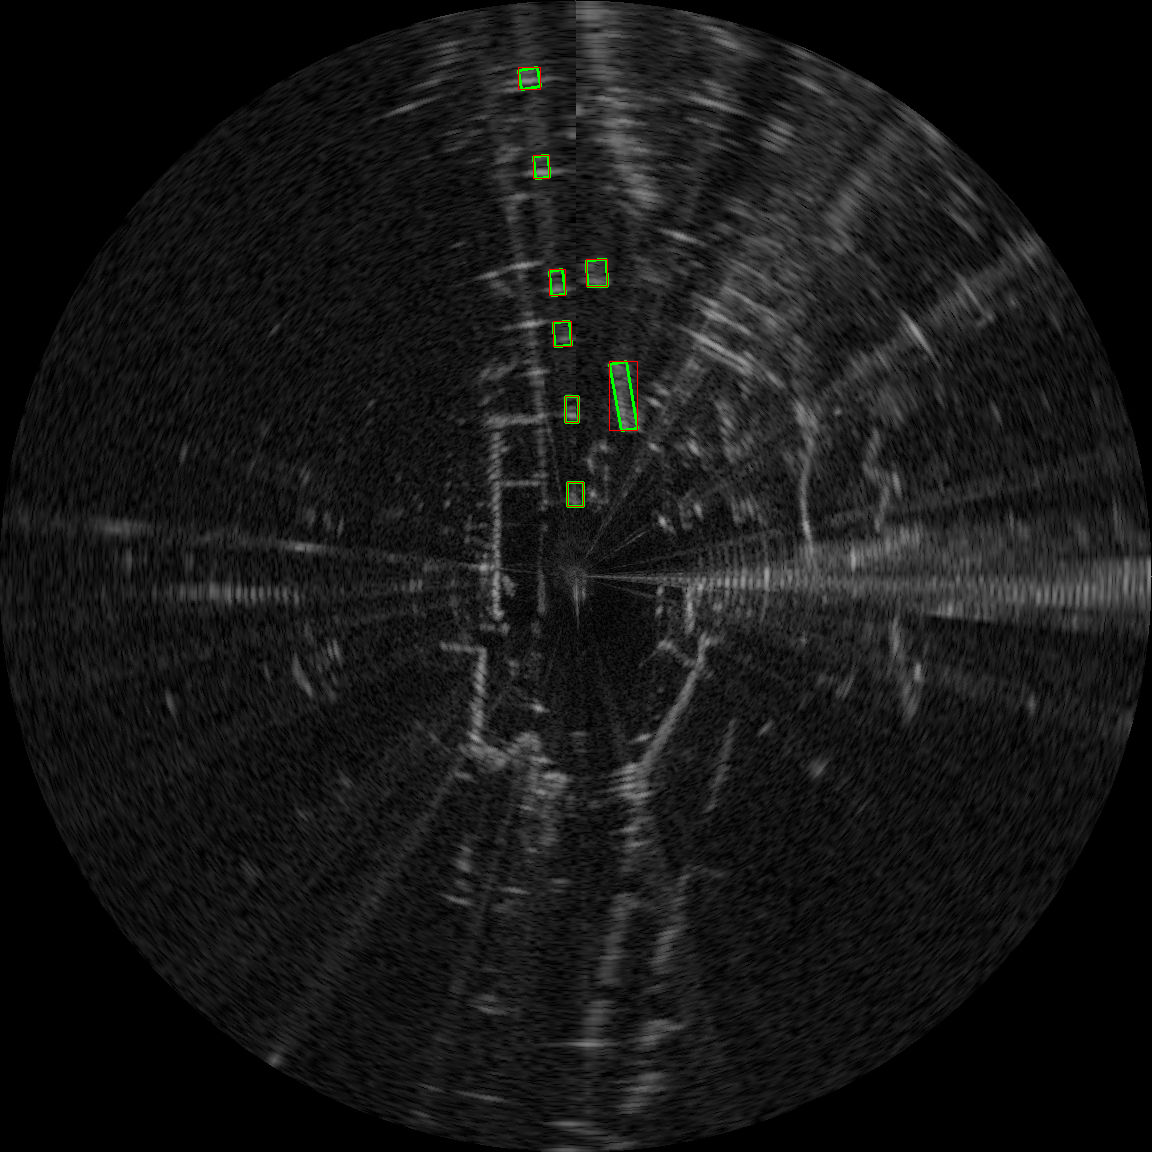

In [17]:
train_mode = 'train_good_and_bad_weather'
root_dir = '/workspace/dataset/radiate_origin'
# dataset = Radiate_Dataset(data_folder, train_mode, transform=True)
img_list = os.listdir(os.path.join(root_dir, train_mode, 'images_radar'))
img_list.sort()
# img_list = np.loadtxt(os.path.join(root_dir, train_mode, 'labels_with_object.txt'))
# print(img_list[110])
i = int(img_list[100][:-5])
print(i)
img_save = os.path.join(root_dir, train_mode, 'images_radar')
label_save = os.path.join(root_dir, train_mode, 'labels')
label_angle_save = os.path.join(root_dir, train_mode, 'labels_angle')
label_OBB_save = os.path.join(root_dir, train_mode, 'labelTxt')
img_info_save = os.path.join(root_dir, train_mode, 'img_info')

img = cv2.imread(os.path.join(img_save, str(i).zfill(5)+'.png'))
img2 = cv2.imread(os.path.join(img_save, str(i).zfill(5)+'.png'))

labels = np.loadtxt(os.path.join(label_save, str(i).zfill(5)+'.txt'),dtype = np.float32)
labels_angle = np.loadtxt(os.path.join(label_angle_save, str(i).zfill(5)+'.txt'),dtype = str)
labels_OBB = np.loadtxt(os.path.join(label_OBB_save,str(i).zfill(5)+'.txt'), dtype=str)
print(labels.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# try:
temp_OBB = labels_OBB[:,0:8]
temp_angle = labels_angle[:,0:5]
# print(temp_angle)
bbox = temp_OBB.astype(np.float32)
bbox = bbox.astype(np.int32)
bbox_angle = temp_angle.astype(np.float32)
for i, label in enumerate(labels):
    x_min = label[1] - label[3] / 2
    x_max = label[1] + label[3] / 2
    y_min = label[2] - label[4] / 2
    y_max = label[2] + label[4] / 2
    cv2.line(img, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), (0,0,255), 2)
    cv2.line(img, (bbox[i][2], bbox[i][3]), (bbox[i][4], bbox[i][5]), (0,0,255), 2)
    cv2.line(img, (bbox[i][4], bbox[i][5]), (bbox[i][6], bbox[i][7]), (0,0,255), 2)
    cv2.line(img, (bbox[i][6], bbox[i][7]), (bbox[i][0], bbox[i][1]), (0,0,255), 2)
    x_min, y_min, x_max, y_max = np.int32(x_min), np.int32(y_min), np.int32(x_max), np.int32(y_max)
    
    points = gen_boundingbox(bbox_angle[i, 0:4], bbox_angle[i, 4])
    points = points.astype(np.int32)
    # print(points.shape)
    cv2.line(img2, (points[0][0], points[1][0]), (points[0][1], points[1][1]), (0,255,0), 2)
    cv2.line(img2, (points[0][1], points[1][1]), (points[0][2], points[1][2]), (0,255,0), 2)
    cv2.line(img2, (points[0][2], points[1][2]), (points[0][3], points[1][3]), (0,255,0), 2)
    cv2.line(img2, (points[0][3], points[1][3]), (points[0][0], points[1][0]), (0,255,0), 2)
    print(bbox[i] == points.T.reshape(-1))
    print(bbox[i])
    print(points.T.reshape(-1))
    
    cv2.rectangle(img2, (x_min, y_min), (x_max, y_max), (255,0,0), 1)
    
img1_show = Image.fromarray(img)
img2_show = Image.fromarray(img2)
img1_show.show()
img2_show.show()
# except:
#     if labels.shape[0] == 5:
#         temp_OBB = labels_OBB[0:8]
#         temp_angle = labels_angle[0:5]
#         # print(temp_angle)
#         bbox = temp_OBB.astype(np.float32)
#         bbox = bbox.astype(np.int32)
#         bbox_angle = temp_angle.astype(np.float32)
#         x_min = labels[1] - labels[3] / 2
#         x_max = labels[1] + labels[3] / 2
#         y_min = labels[2] - labels[4] / 2
#         y_max = labels[2] + labels[4] / 2
#         cv2.line(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,0,255), 2)
#         cv2.line(img, (bbox[2], bbox[3]), (bbox[4], bbox[5]), (0,0,255), 2)
#         cv2.line(img, (bbox[4], bbox[5]), (bbox[6], bbox[7]), (0,0,255), 2)
#         cv2.line(img, (bbox[6], bbox[7]), (bbox[0], bbox[1]), (0,0,255), 2)
#         x_min, y_min, x_max, y_max = np.int32(x_min), np.int32(y_min), np.int32(x_max), np.int32(y_max)
       
#         # points = gen_boundingbox(bbox_angle[i, 0:4], bbox_angle[i, 4])
#         # points = points.astype(np.int32)
#         # # print(points.shape)
#         # cv2.line(img2, (points[0][0], points[1][0]), (points[0][1], points[1][1]), (0,255,0), 2)
#         # cv2.line(img2, (points[0][1], points[1][1]), (points[0][2], points[1][2]), (0,255,0), 2)
#         # cv2.line(img2, (points[0][2], points[1][2]), (points[0][3], points[1][3]), (0,255,0), 2)
#         # cv2.line(img2, (points[0][3], points[1][3]), (points[0][0], points[1][0]), (0,255,0), 2)
#         # print(bbox[i] == points.T.reshape(-1))
#         # print(bbox[i])
#         # print(points.T.reshape(-1))
        
#         cv2.rectangle(img2, (x_min, y_min), (x_max, y_max), (255,0,0), 1)
        
#     img1_show = Image.fromarray(img)
#     img2_show = Image.fromarray(img2)
#     img1_show.show()
#     img2_show.show()

In [10]:
train_mode = 'test'
root_dir = '/workspace/dataset/radiate_centercrop'

img_root = os.path.join(root_dir, train_mode, 'images')
img_list = os.listdir(img_root)
img_list.sort()
print(len(img_list))

11307
